## Correlation between hfds/SST and NAO indices

This is test notebook for checking correlation between NAO indices and surface heat flux / SST anomalies. 

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import gsw as gsw
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Read raw data for one year

var_list = ['tos', 'hfds', 'sos']

ppdir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

year = 2008

ds = []

for var in var_list:
    ds1 = []
    for r in range(0,10):
        var_path = "s" + str(year) +"-r" + str(r+1) + "i1p1f2/Omon/"+ var +"/gn/files/d20200417/"
        d = xr.open_mfdataset(ppdir + var_path + "*.nc")
        d = d.drop(['vertices_latitude', 'vertices_longitude', 'time_bnds'])
        ds1.append(d)
    
    ds1 = xr.concat(ds1, dim='r')
    ds1 = ds1.isel(i=slice(749,1199), j = slice(699, 1149))
    
    ds.append(ds1)

ds = xr.merge(ds)
print(ds)

<xarray.Dataset>
Dimensions:    (time: 125, j: 450, i: 450, r: 10)
Coordinates:
  * time       (time) object 2008-11-16 00:00:00 ... 2019-03-16 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: r
Data variables:
    tos        (r, time, j, i) float32 dask.array<chunksize=(1, 2, 450, 450), meta=np.ndarray>
    hfds       (r, time, j, i) float32 dask.array<chunksize=(1, 2, 450, 450), meta=np.ndarray>
    sos        (r, time, j, i) float32 dask.array<chunksize=(1, 2, 450, 450), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
   

In [3]:
# Read drift data to compute anomalies

var_list = ['tos', 'hfds', 'sos']

ppdir_drift="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_1970_2016_Method_DCPP/"

ds_drift = []
    
for var in var_list:

    ds2 = []
    
    for lead_year in range(0, 11):

        ds1 =[]
        for r in range(1,11):

            d = xr.open_dataset(ppdir_drift + var +"/" + "Drift_" + var + "_r" + str(r) + "_Lead_Year_" + 
                                str(lead_year + 1) + ".nc", decode_times= False)
            d = d.assign(time = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time'])), 1))
            ds1.append(d)

        ds1 = xr.concat(ds1, dim='r')
        ds2.append(ds1)

    ds2 = xr.concat(ds2, dim='time')
    
    ds_drift.append(ds2)

ds_drift = xr.merge(ds_drift)

print(ds_drift)

<xarray.Dataset>
Dimensions:    (j: 450, i: 450, r: 10, time: 125)
Coordinates:
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 117 118 119 120 121 122 123 124
Dimensions without coordinates: r
Data variables:
    tos        (r, time, j, i) float32 26.73 26.74 26.75 ... -1.253 -1.672
    hfds       (r, time, j, i) float32 8.904 9.007 8.955 ... -175.5 -106.9
    sos        (r, time, j, i) float32 33.66 33.65 33.63 ... 34.5 34.46 34.44


In [4]:
ds_drift = ds_drift.drop('time')

ds_anom = ds - ds_drift

print(ds_anom)

<xarray.Dataset>
Dimensions:    (time: 125, j: 450, i: 450, r: 10)
Coordinates:
  * time       (time) object 2008-11-16 00:00:00 ... 2019-03-16 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: r
Data variables:
    tos        (r, time, j, i) float32 dask.array<chunksize=(1, 2, 450, 450), meta=np.ndarray>
    hfds       (r, time, j, i) float32 dask.array<chunksize=(1, 2, 450, 450), meta=np.ndarray>
    sos        (r, time, j, i) float32 dask.array<chunksize=(1, 2, 450, 450), meta=np.ndarray>


#### Winter season data

Following Ma et al. (2020), we compute correlation between heat flux anomalies and SST anomalies across all ensemble members. For this, first we isolate data for Jan and Feb months. Then, we compute correlation for Jan-Jan data and Jan-Feb data using xarray inbuilt correlation command.

In [10]:
ds_J = ds_anom.sel(time = ds_anom['time.month'] == 1)
ds_F = ds_anom.sel(time = ds_anom['time.month'] == 2)

In [11]:
print(ds_J)

<xarray.Dataset>
Dimensions:    (time: 11, j: 450, i: 450, r: 10)
Coordinates:
  * time       (time) object 2009-01-16 00:00:00 ... 2019-01-16 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: r
Data variables:
    tos        (r, time, j, i) float32 dask.array<chunksize=(1, 1, 450, 450), meta=np.ndarray>
    hfds       (r, time, j, i) float32 dask.array<chunksize=(1, 1, 450, 450), meta=np.ndarray>


In [22]:
corr_JJ = xr.corr(ds_J['hfds'], ds_J['tos'], dim='r').compute()
corr_JF = xr.corr(ds_J['hfds'].drop('time'), ds_F['tos'].drop('time'), dim='r').compute()

/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [17]:
print(corr_JJ)

<xarray.DataArray (time: 11, j: 450, i: 450)>
dask.array<truediv, shape=(11, 450, 450), dtype=float64, chunksize=(1, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 2009-01-16 00:00:00 ... 2019-01-16 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41


In [18]:
print(corr_JF)

<xarray.DataArray (time: 11, j: 450, i: 450)>
dask.array<truediv, shape=(11, 450, 450), dtype=float64, chunksize=(1, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: time


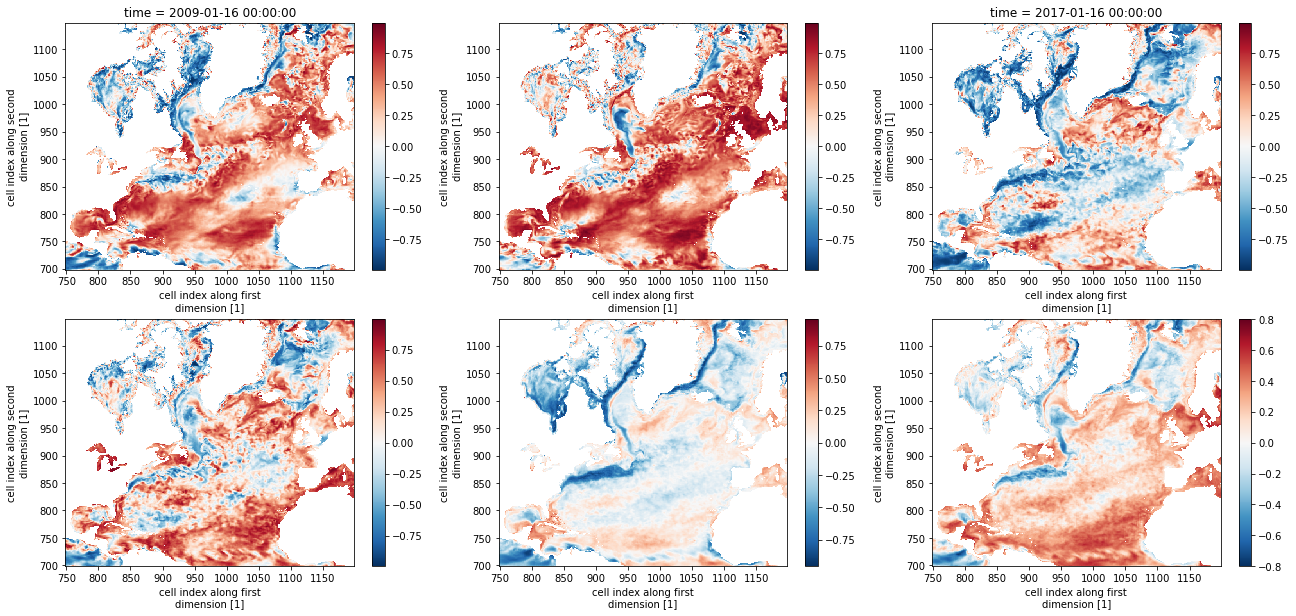

In [23]:
fig = plt.figure(figsize=[22,10])

plt.subplot(2,3,1)
corr_JJ.isel(time=0).plot()

plt.subplot(2,3,2)
corr_JF.isel(time=0).plot()

plt.subplot(2,3,3)
corr_JJ.isel(time=8).plot()

plt.subplot(2,3,4)
corr_JF.isel(time=8).plot()

plt.subplot(2,3,5)
corr_JJ.mean('time').plot()

plt.subplot(2,3,6)
corr_JF.mean('time').plot()

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    #ax.coastlines()
    ax.add_feature(cfeature.LAND) #facecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/users/hkhatri/.conda/envs/py-xgcm/

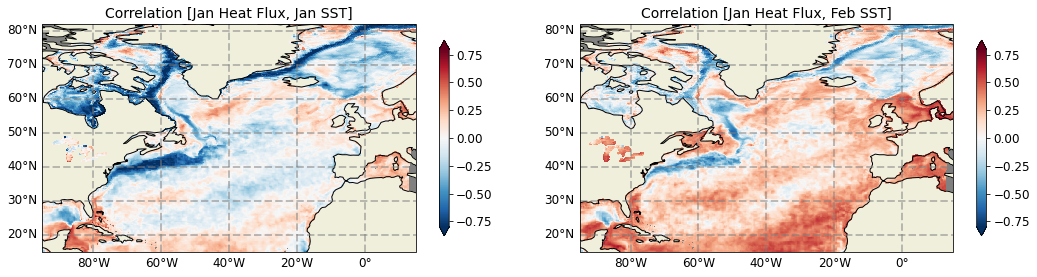

In [34]:
lat_lon_ext = [-95., 15., 15., 82.]
grid1 = plt.GridSpec(1, 2, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[18,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')

tmp = corr_JJ.mean('time') #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-0.8, vmax=0.8, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Correlation [Jan Heat Flux, Jan SST]')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')

tmp = corr_JF.mean('time') #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-0.8, vmax=0.8, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Correlation [Jan Heat Flux, Feb SST]')

#### Correlation with NAO indices

Here, we compute correlation between DJF NAO indices and heat flux / SST anomalies.

In [35]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

print(ds_NAO)

<xarray.Dataset>
Dimensions:     (start_year: 57, r: 10, time: 125)
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
Dimensions without coordinates: r, time
Data variables:
    NAO         (start_year, r, time) float64 ...
    P_south     (start_year, r, time) float64 ...
    P_north     (start_year, r, time) float64 ...
    time_val    (start_year, time) object ...


In [38]:
NAO = ds_NAO['NAO'].copy()
tim = ds_anom['time']
NAO = NAO.assign_coords(time=tim)

NAO = NAO.resample(time='QS-DEC').mean('time')
NAO = NAO.sel(time = NAO['time.season'] == 'DJF')

#NAO = NAO.rename({'time': 'lead_year'}).drop('lead_year')

NAO = NAO.sel(start_year = year)

print(NAO)

<xarray.DataArray 'NAO' (r: 10, time: 11)>
array([[-0.75094571,  3.25627914, -0.09564862, -0.49063491, -1.70753621,
         1.15081456,  1.19849195,  1.67751573, -0.2023194 , -0.071477  ,
         0.58665066],
       [-0.32044782,  1.25559396,  0.09757836, -0.5789269 , -1.35744934,
        -2.78751445,  1.07392741,  1.92947241,  2.1119818 , -0.63521897,
         1.76051473],
       [-1.76955444, -2.28360724, -1.42861654,  2.54909671,  2.53917701,
         0.95844843,  1.14924448,  1.34697309,  1.58268562,  0.04994989,
         1.83843344],
       [ 0.11432412,  0.54953455,  1.38432721,  2.36348115,  1.96500051,
        -0.3431881 , -3.2722462 , -3.14654008,  0.3635755 ,  0.88235451,
         1.09437916],
       [-2.01629358, -4.07200501,  2.01607167,  0.95503128, -0.39985785,
         2.11445016, -0.68473959,  1.43630607,  0.96711957,  0.08629899,
        -1.5676518 ],
       [ 1.39557332,  0.96909529, -0.08945934,  0.91814336, -1.67509424,
        -2.04057653, -1.20128524,  0.4428075

In [39]:
ds_DJF = ds_anom.resample(time='QS-DEC').mean('time')
ds_DJF = ds_DJF.sel(time = ds_DJF['time.season'] == 'DJF')

print(ds_DJF)

<xarray.Dataset>
Dimensions:    (time: 11, j: 450, i: 450, r: 10)
Coordinates:
  * time       (time) object 2008-12-01 00:00:00 ... 2018-12-01 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Dimensions without coordinates: r
Data variables:
    tos        (time, r, j, i) float32 dask.array<chunksize=(1, 1, 450, 450), meta=np.ndarray>
    hfds       (time, r, j, i) float32 dask.array<chunksize=(1, 1, 450, 450), meta=np.ndarray>


In [40]:
corr_NAO_hfds = xr.corr(ds_DJF['hfds'], NAO, dim='r').compute()
corr_NAO_SST = xr.corr(ds_DJF['tos'], NAO, dim='r').compute()

/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/users/hkhatri/.conda/envs/py-xgcm/

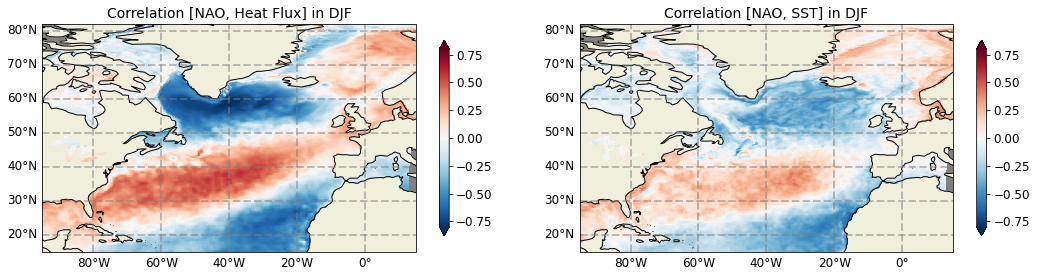

In [41]:
lat_lon_ext = [-95., 15., 15., 82.]
grid1 = plt.GridSpec(1, 2, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[18,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')

tmp = corr_NAO_hfds.mean('time') #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-0.8, vmax=0.8, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Correlation [NAO, Heat Flux] in DJF')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')

tmp = corr_NAO_SST.mean('time') #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-0.8, vmax=0.8, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Correlation [NAO, SST] in DJF')

The tripole pattern looks very similar to correlation (jet speed indices and heat flux anomalies) plots in Ma et al. (2020).

#### Potential density calculation

We use gsw library to compute potential density on the ocena surface. We also compare annualy-averaged $\rho$ computed from monthly fields vs annual mean T/S fields. 

In [7]:
T = ds['tos'].sel(time = ds['time.year'] == 2009).isel(r=0)
S = ds['sos'].sel(time = ds['time.year'] == 2009).isel(r=0)

print(T,S)
#gsw.density.sigma0(SA, CT)

<xarray.DataArray 'tos' (time: 12, j: 450, i: 450)>
dask.array<getitem, shape=(12, 450, 450), dtype=float32, chunksize=(12, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 2009-01-16 00:00:00 ... 2009-12-16 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    longitude  (j, i) float32 -99.75 -99.5 -99.25 -99.0 ... 51.08 51.24 51.41
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    original_name:  mo: (variable_name: tos)
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello <xarray.DataArray 'sos' (time: 12, j: 450, i: 450)>
dask.array<getitem, shape=(12, 450, 450), dtype=float

In [10]:
rho_month = gsw.density.sigma0(S, T).compute()
rho_year = gsw.density.sigma0(S.mean('time'), T.mean('time')).compute()

/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/users/hkhatri/.conda/envs/py-xgcm/

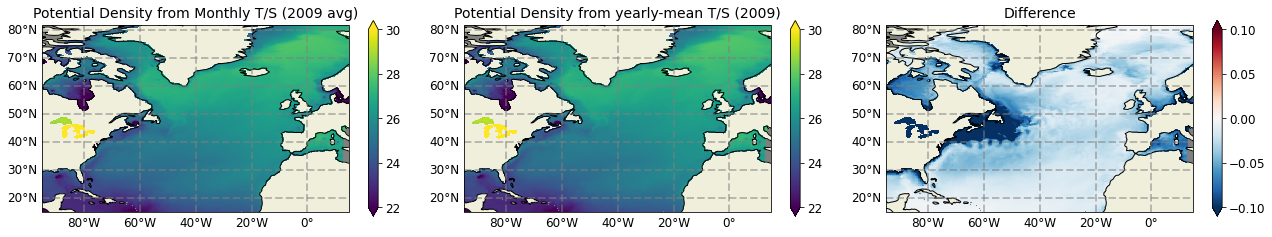

In [18]:
lat_lon_ext = [-95., 15., 15., 82.]
grid1 = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[22,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')

tmp = rho_month.mean('time') #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=22., vmax=30., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='viridis', title=r'Potential Density from Monthly T/S (2009 avg)')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
tmp = rho_year #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=22., vmax=30., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='viridis', title=r'Potential Density from yearly-mean T/S (2009)')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
tmp = - rho_year + rho_month.mean('time') #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-0.1, vmax=0.1, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Difference')

## Check NAO and hfds correlations

The correlations were computed across hindcasts for each ensemble separately while retaining informationa about lead time.

In [7]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/"

ds_corr = xr.open_dataset(ppdir + "Correlation_NAO_hfds_r2.nc")

print(ds_corr)

<xarray.Dataset>
Dimensions:    (time: 41, j: 450, i: 450)
Coordinates:
  * time       (time) object 1960-12-01 00:00:00 ... 1970-12-01 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 ...
    longitude  (j, i) float32 ...
Data variables:
    hfds       (time, j, i) float64 ...


In [8]:
ds_corr['time.season']

<xarray.DataArray 'season' (time: 41)>
array(['DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON', 'DJF',
       'MAM', 'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM',
       'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM', 'JJA',
       'SON', 'DJF', 'MAM', 'JJA', 'SON', 'DJF', 'MAM', 'JJA', 'SON',
       'DJF', 'MAM', 'JJA', 'SON', 'DJF'], dtype='<U3')
Coordinates:
  * time     (time) object 1960-12-01 00:00:00 ... 1970-12-01 00:00:00

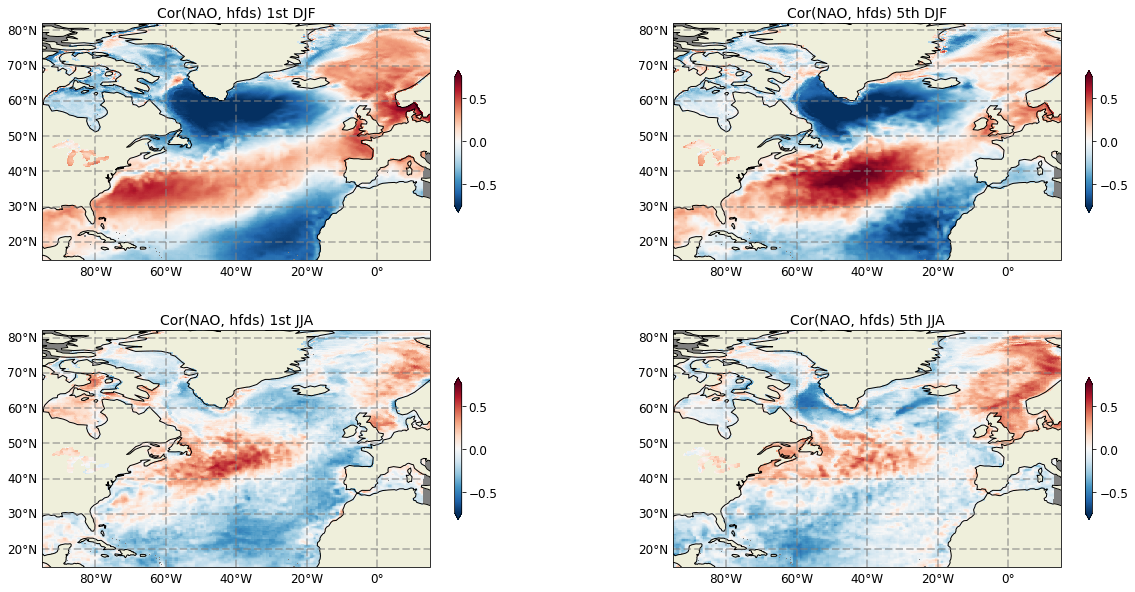

In [9]:
lat_lon_ext = [-95., 15., 15., 82.]
grid1 = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[20,10])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')

tmp = ds_corr['hfds'].isel(time=0) #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-0.75, vmax=0.75, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Cor(NAO, hfds) 1st DJF')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
tmp = ds_corr['hfds'].isel(time=16)
p = plot_sec(ax, tmp, vmin=-0.75, vmax=0.75, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Cor(NAO, hfds) 5th DJF')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
tmp = ds_corr['hfds'].isel(time=2)
p = plot_sec(ax, tmp, vmin=-0.75, vmax=0.75, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Cor(NAO, hfds) 1st JJA')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
tmp = ds_corr['hfds'].isel(time=18)
p = plot_sec(ax, tmp, vmin=-0.75, vmax=0.75, vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='RdBu_r', title=r'Cor(NAO, hfds) 5th JJA')